In [104]:
import os
import numpy as np
import pandas as pd
import deepdish as dd

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, PredefinedSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, roc_curve, auc, matthews_corrcoef, make_scorer
from sklearn.ensemble import RandomForestClassifier

In [56]:
def get_scaled_abl(ft):
    unpack = list((*ft,))
    tr_selection = train_features[unpack].values
    vl_selection = val_features[unpack].values
    ts_selection = test_features[unpack].values
    scaler = MinMaxScaler()
    scaler = scaler.fit(np.concatenate((tr_selection, vl_selection, ts_selection), axis=0))
    return scaler.transform(tr_selection), scaler.transform(vl_selection), scaler.transform(ts_selection), unpack

In [105]:
train = dd.io.load('../../splits/train.h5')
val = dd.io.load('../../splits/val.h5')
test = dd.io.load('../../splits/test.h5')
y_train = np.load('../../splits/y_train.npy')
y_val = np.load('../../splits/y_val.npy')
y_test = np.load('../../splits/y_test.npy')

In [106]:
y_train = y_train * 100
y_val = y_val * 100
y_test = y_test * 100

In [4]:
df_feat = pd.read_csv('../../datasets/dataset_extracted_features.csv')

In [5]:
df_feat

,Seq1,Seq2,Aln,GC1,GC2,SingleCon1,SingleCon2,PairCon1,PairCon2,SingleMFE1,SingleMFE2,Yield,Label
0,AGTACAAGTAGGACAGGAAGATA,TATCTTCCTGTCCTACTCGTACT,106,39.130435,43.478261,0.999957,0.999974,0.000022,0.000013,0.000000,0.000000,0.974025,1
1,GAGTTCCGGTTGCCTTTCA,GAGTTCCGGGTGCCTTTCA,12,52.631579,57.894737,0.999844,0.999739,0.000078,0.000130,0.000000,0.000000,0.000193,0
2,TCTGGAACTAGTGCAATTTAGC,TCTAAATTGCACTAGTTCCAGA,101,40.909091,36.363636,0.999556,0.999598,0.000222,0.000201,0.000000,0.000000,0.991153,1
3,GGCGCGCGACGCGACATCCGATAAGA,TCTTATCGGATCTCGCGTCGCGCGCC,121,65.384615,65.384615,0.999455,0.999183,0.000273,0.000408,-2.595847,-1.870977,0.999227,1
4,GTGTACCATACCATGAACGCCGGA,TCCGGCGTCATGGTATGGTACAC,110,54.166667,56.521739,0.998893,0.999652,0.000554,0.000174,0.000000,0.000000,0.996585,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2556971,AGCAAGGCACAGGACTTAGTACCAAA,TTTGGTACTAAGTCCTGTGCCGCT,113,46.153846,50.000000,0.999938,0.999916,0.000031,0.000042,-0.317577,0.000000,0.995240,1
2556972,CAGGCTGAGACCTAACTCTTTAGCC,GGCTAAAAGGTTAGGTCTCAGCCTG,110,52.000000,52.000000,0.999786,0.999896,0.000107,0.000052,0.000000,0.000000,0.973733,1
2556973,CATATCAACTCCAGGAATCCTT,AAGGATTCCTGCAGATGATATG,92,40.909091,40.909091,0.999334,0.998677,0.000333,0.000662,0.000000,0.000000,0.529762,1
2556974,GAATGCAGAGTTCGATGTCGGT,ACCAGTACACATCGAACTCTGCATTC,96,50.000000,46.153846,0.999855,0.999893,0.000073,0.000053,0.000000,0.000000,0.984665,1


In [6]:
train_features = df_feat.loc[(df_feat['Seq1'].isin([item[0] for item in train])) & (df_feat['Seq2'].isin([item[1] for item in train]))]
val_features = df_feat.loc[(df_feat['Seq1'].isin([item[0] for item in val])) & (df_feat['Seq2'].isin([item[1] for item in val]))]
test_features = df_feat.loc[(df_feat['Seq1'].isin([item[0] for item in test])) & (df_feat['Seq2'].isin([item[1] for item in test]))]

In [9]:
train_feat = train_features[['Aln', 'GC1', 'GC2', 'SingleCon1', 'SingleCon2', 'PairCon1', 'PairCon2', 'SingleMFE1', 'SingleMFE2']].values
val_feat = val_features[['Aln', 'GC1', 'GC2', 'SingleCon1', 'SingleCon2', 'PairCon1', 'PairCon2', 'SingleMFE1', 'SingleMFE2']].values
test_feat = test_features[['Aln', 'GC1', 'GC2', 'SingleCon1', 'SingleCon2', 'PairCon1', 'PairCon2', 'SingleMFE1', 'SingleMFE2']].values

single_mfe = ['SingleMFE1', 'SingleMFE2']
pair_con = ['PairCon1', 'PairCon2']
single_con = ['SingleCon1', 'SingleCon2']
gc = ['GC1', 'GC2']
aln = ['Aln']

In [10]:
train_labels = train_features[['Label']].values.squeeze()
val_labels = val_features[['Label']].values.squeeze()
test_labels = test_features[['Label']].values.squeeze()

In [11]:
feats = [aln, aln + gc, aln + gc + single_con, aln + gc + pair_con, aln + gc + single_mfe, aln + gc + single_mfe + pair_con, aln + gc + single_mfe + single_con, aln + gc + single_mfe + single_con + pair_con, single_con, pair_con, single_mfe, gc + single_mfe + single_con + pair_con]

In [36]:
scaler = MinMaxScaler()
scaler = scaler.fit(np.concatenate((train_feat, val_feat, test_feat), axis=0))
scaled_train = scaler.transform(train_feat)
scaled_val = scaler.transform(val_feat)
scaled_test = scaler.transform(test_feat)

### LDA

['Aln']


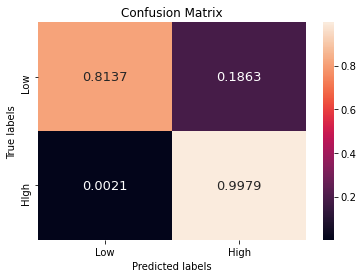

Precision: 0.9966  0.8731
Recall: 0.8137  0.9979
F1-Score 0.8959  0.9313
MCC 0.8401
AUROC 0.9058
XXXXX
['Aln', 'GC1', 'GC2']


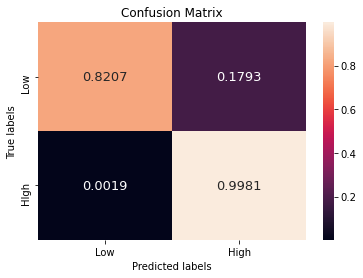

Precision: 0.9970  0.8773
Recall: 0.8207  0.9981
F1-Score 0.9003  0.9338
MCC 0.8460
AUROC 0.9094
XXXXX
['Aln', 'GC1', 'GC2', 'SingleCon1', 'SingleCon2']


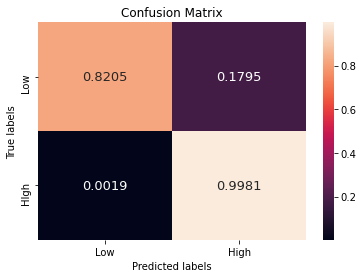

Precision: 0.9970  0.8772
Recall: 0.8205  0.9981
F1-Score 0.9002  0.9337
MCC 0.8459
AUROC 0.9093
XXXXX
['Aln', 'GC1', 'GC2', 'PairCon1', 'PairCon2']


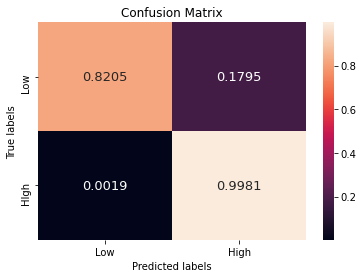

Precision: 0.9970  0.8772
Recall: 0.8205  0.9981
F1-Score 0.9002  0.9337
MCC 0.8459
AUROC 0.9093
XXXXX
['Aln', 'GC1', 'GC2', 'SingleMFE1', 'SingleMFE2']


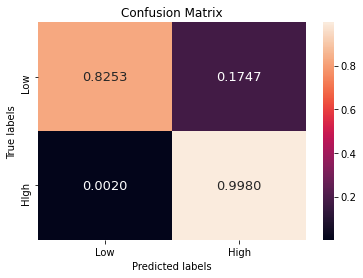

Precision: 0.9969  0.8801
Recall: 0.8253  0.9980
F1-Score 0.9030  0.9353
MCC 0.8497
AUROC 0.9117
XXXXX
['Aln', 'GC1', 'GC2', 'SingleMFE1', 'SingleMFE2', 'PairCon1', 'PairCon2']


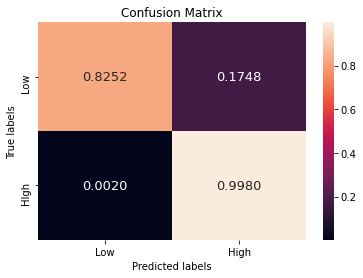

Precision: 0.9969  0.8800
Recall: 0.8252  0.9980
F1-Score 0.9030  0.9353
MCC 0.8497
AUROC 0.9116
XXXXX
['Aln', 'GC1', 'GC2', 'SingleMFE1', 'SingleMFE2', 'SingleCon1', 'SingleCon2']


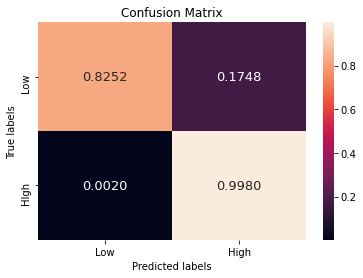

Precision: 0.9969  0.8800
Recall: 0.8252  0.9980
F1-Score 0.9030  0.9353
MCC 0.8497
AUROC 0.9116
XXXXX
['Aln', 'GC1', 'GC2', 'SingleMFE1', 'SingleMFE2', 'SingleCon1', 'SingleCon2', 'PairCon1', 'PairCon2']


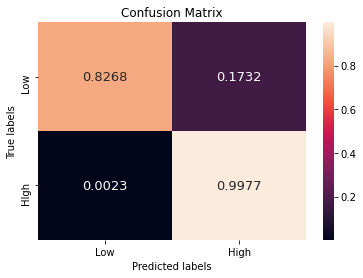

Precision: 0.9964  0.8810
Recall: 0.8268  0.9977
F1-Score 0.9037  0.9357
MCC 0.8505
AUROC 0.9122
XXXXX
['SingleCon1', 'SingleCon2']


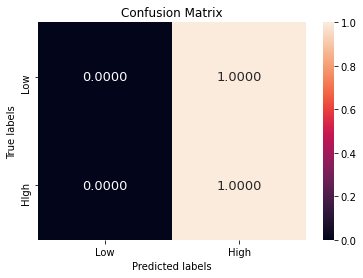

C:\Users\david\miniconda3\envs\pt1.8-cuda11.1\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\david\miniconda3\envs\pt1.8-cuda11.1\lib\site-packages\sklearn\metrics\_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Precision: 0.0000  0.5623
Recall: 0.0000  1.0000
F1-Score 0.0000  0.7198
MCC 0.0000
AUROC 0.5000
XXXXX
['PairCon1', 'PairCon2']


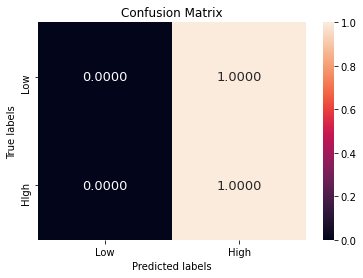

C:\Users\david\miniconda3\envs\pt1.8-cuda11.1\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\david\miniconda3\envs\pt1.8-cuda11.1\lib\site-packages\sklearn\metrics\_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Precision: 0.0000  0.5623
Recall: 0.0000  1.0000
F1-Score 0.0000  0.7198
MCC 0.0000
AUROC 0.5000
XXXXX
['SingleMFE1', 'SingleMFE2']


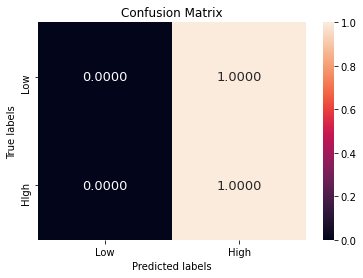

C:\Users\david\miniconda3\envs\pt1.8-cuda11.1\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\david\miniconda3\envs\pt1.8-cuda11.1\lib\site-packages\sklearn\metrics\_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Precision: 0.0000  0.5623
Recall: 0.0000  1.0000
F1-Score 0.0000  0.7198
MCC 0.0000
AUROC 0.5000
XXXXX
['GC1', 'GC2', 'SingleMFE1', 'SingleMFE2', 'SingleCon1', 'SingleCon2', 'PairCon1', 'PairCon2']


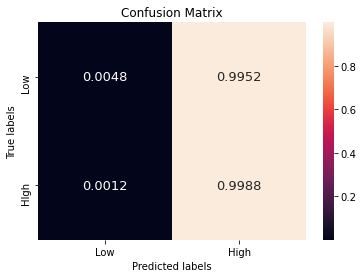

Precision: 0.7504  0.5632
Recall: 0.0048  0.9988
F1-Score 0.0094  0.7202
MCC 0.0332
AUROC 0.5018
XXXXX


In [95]:
for f in feats:
    tr, vl, ts, cols = get_scaled_abl(f)
    lda = LDA(shrinkage=0, solver='eigen')
    lda.fit(tr, train_labels)
    y_pred_lda = lda.predict(ts)
    
    print(cols)
    report(test_labels, y_pred_lda)
    print('XXXXX')

## QDA

['Aln']


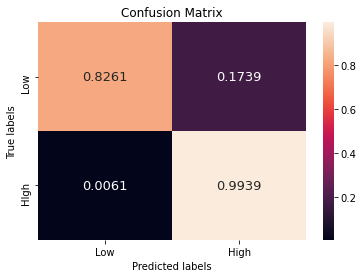

Precision: 0.9907  0.8801
Recall: 0.8261  0.9939
F1-Score 0.9009  0.9336
MCC 0.8450
AUROC 0.9100
XXXXX
['Aln', 'GC1', 'GC2']


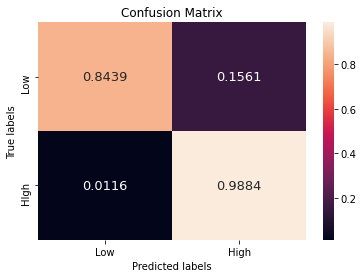

Precision: 0.9827  0.8905
Recall: 0.8439  0.9884
F1-Score 0.9080  0.9369
MCC 0.8525
AUROC 0.9162
XXXXX
['Aln', 'GC1', 'GC2', 'SingleCon1', 'SingleCon2']


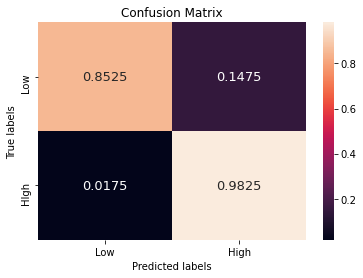

Precision: 0.9743  0.8954
Recall: 0.8525  0.9825
F1-Score 0.9094  0.9369
MCC 0.8522
AUROC 0.9175
XXXXX
['Aln', 'GC1', 'GC2', 'PairCon1', 'PairCon2']


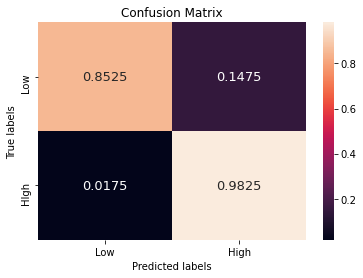

Precision: 0.9743  0.8954
Recall: 0.8525  0.9825
F1-Score 0.9094  0.9369
MCC 0.8522
AUROC 0.9175
XXXXX
['Aln', 'GC1', 'GC2', 'SingleMFE1', 'SingleMFE2']


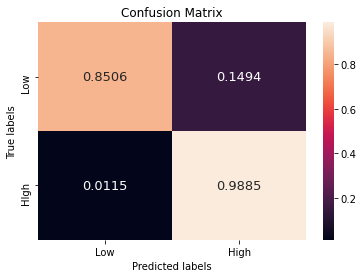

Precision: 0.9829  0.8947
Recall: 0.8506  0.9885
F1-Score 0.9120  0.9393
MCC 0.8581
AUROC 0.9195
XXXXX
['Aln', 'GC1', 'GC2', 'SingleMFE1', 'SingleMFE2', 'PairCon1', 'PairCon2']


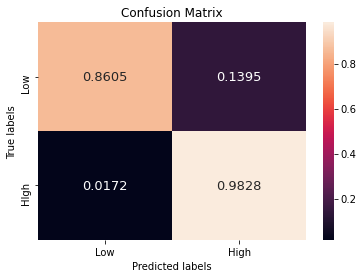

Precision: 0.9750  0.9005
Recall: 0.8605  0.9828
F1-Score 0.9142  0.9399
MCC 0.8592
AUROC 0.9216
XXXXX
['Aln', 'GC1', 'GC2', 'SingleMFE1', 'SingleMFE2', 'SingleCon1', 'SingleCon2']


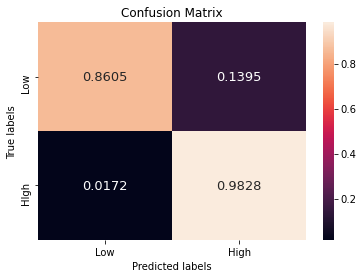

Precision: 0.9750  0.9005
Recall: 0.8605  0.9828
F1-Score 0.9142  0.9399
MCC 0.8592
AUROC 0.9216
XXXXX


C:\Users\david\miniconda3\envs\pt1.8-cuda11.1\lib\site-packages\sklearn\discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


['Aln', 'GC1', 'GC2', 'SingleMFE1', 'SingleMFE2', 'SingleCon1', 'SingleCon2', 'PairCon1', 'PairCon2']


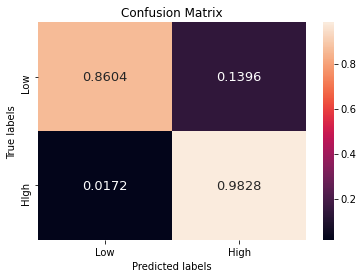

Precision: 0.9749  0.9005
Recall: 0.8604  0.9828
F1-Score 0.9141  0.9398
MCC 0.8591
AUROC 0.9216
XXXXX
['SingleCon1', 'SingleCon2']


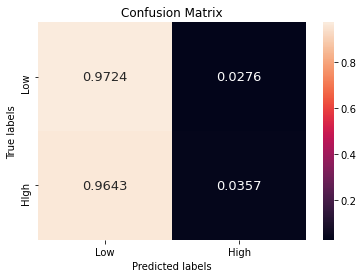

Precision: 0.4398  0.6240
Recall: 0.9724  0.0357
F1-Score 0.6056  0.0675
MCC 0.0227
AUROC 0.5040
XXXXX
['PairCon1', 'PairCon2']


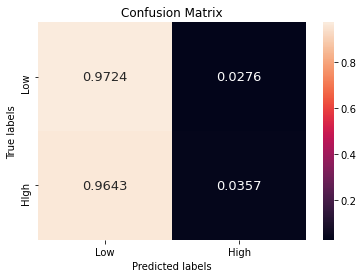

Precision: 0.4398  0.6240
Recall: 0.9724  0.0357
F1-Score 0.6056  0.0675
MCC 0.0227
AUROC 0.5040
XXXXX
['SingleMFE1', 'SingleMFE2']


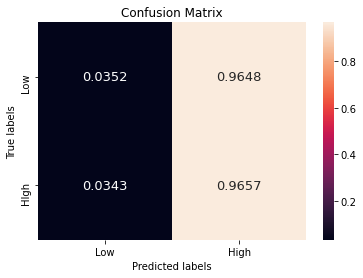

Precision: 0.4444  0.5625
Recall: 0.0352  0.9657
F1-Score 0.0653  0.7109
MCC 0.0026
AUROC 0.5005
XXXXX


C:\Users\david\miniconda3\envs\pt1.8-cuda11.1\lib\site-packages\sklearn\discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


['GC1', 'GC2', 'SingleMFE1', 'SingleMFE2', 'SingleCon1', 'SingleCon2', 'PairCon1', 'PairCon2']


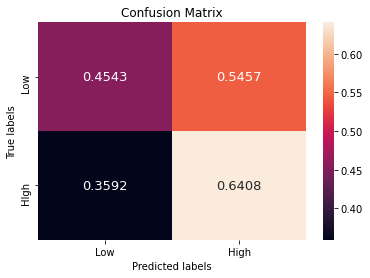

Precision: 0.4961  0.6014
Recall: 0.4543  0.6408
F1-Score 0.4743  0.6205
MCC 0.0963
AUROC 0.5475
XXXXX


In [96]:
for f in feats:
    tr, vl, ts, cols = get_scaled_abl(f)
    qda = QDA()
    qda.fit(tr, train_labels)
    y_pred_qda = qda.predict(ts)
    
    print(cols)
    report(test_labels, y_pred_qda)
    print('XXXXX')

## RF

['Aln']


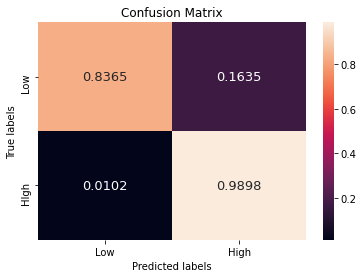

Precision: 0.9846  0.8861
Recall: 0.8365  0.9898
F1-Score 0.9045  0.9351
MCC 0.8482
AUROC 0.9131
XXXXX
['Aln', 'GC1', 'GC2']


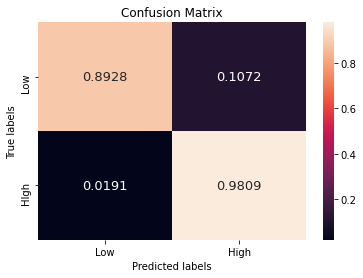

Precision: 0.9732  0.9216
Recall: 0.8928  0.9809
F1-Score 0.9313  0.9503
MCC 0.8842
AUROC 0.9368
XXXXX
['Aln', 'GC1', 'GC2', 'SingleCon1', 'SingleCon2']


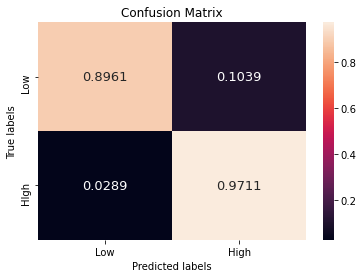

Precision: 0.9602  0.9231
Recall: 0.8961  0.9711
F1-Score 0.9271  0.9465
MCC 0.8752
AUROC 0.9336
XXXXX
['Aln', 'GC1', 'GC2', 'PairCon1', 'PairCon2']


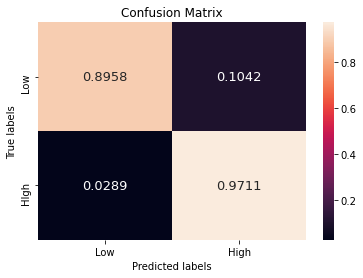

Precision: 0.9602  0.9229
Recall: 0.8958  0.9711
F1-Score 0.9269  0.9464
MCC 0.8749
AUROC 0.9334
XXXXX
['Aln', 'GC1', 'GC2', 'SingleMFE1', 'SingleMFE2']


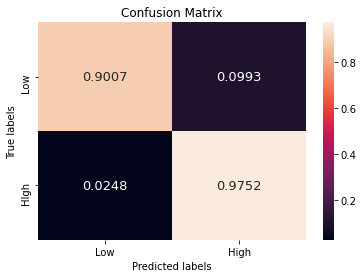

Precision: 0.9659  0.9266
Recall: 0.9007  0.9752
F1-Score 0.9322  0.9503
MCC 0.8842
AUROC 0.9380
XXXXX
['Aln', 'GC1', 'GC2', 'SingleMFE1', 'SingleMFE2', 'PairCon1', 'PairCon2']


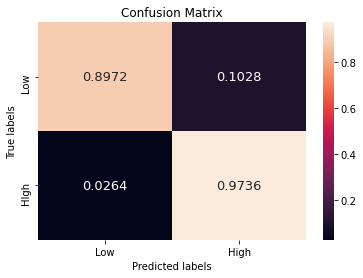

Precision: 0.9635  0.9240
Recall: 0.8972  0.9736
F1-Score 0.9292  0.9482
MCC 0.8791
AUROC 0.9354
XXXXX
['Aln', 'GC1', 'GC2', 'SingleMFE1', 'SingleMFE2', 'SingleCon1', 'SingleCon2']


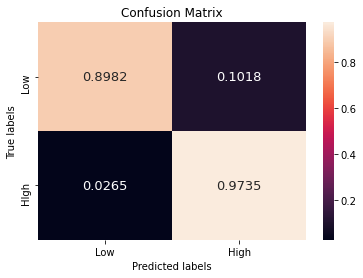

Precision: 0.9634  0.9247
Recall: 0.8982  0.9735
F1-Score 0.9297  0.9485
MCC 0.8799
AUROC 0.9358
XXXXX
['Aln', 'GC1', 'GC2', 'SingleMFE1', 'SingleMFE2', 'SingleCon1', 'SingleCon2', 'PairCon1', 'PairCon2']


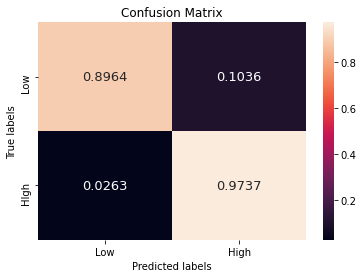

Precision: 0.9637  0.9235
Recall: 0.8964  0.9737
F1-Score 0.9288  0.9479
MCC 0.8786
AUROC 0.9350
XXXXX
['SingleCon1', 'SingleCon2']


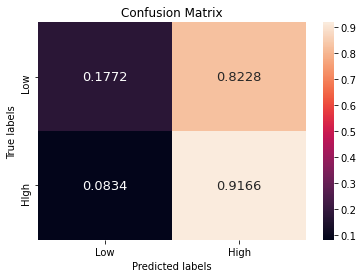

Precision: 0.6232  0.5887
Recall: 0.1772  0.9166
F1-Score 0.2759  0.7169
MCC 0.1410
AUROC 0.5469
XXXXX
['PairCon1', 'PairCon2']


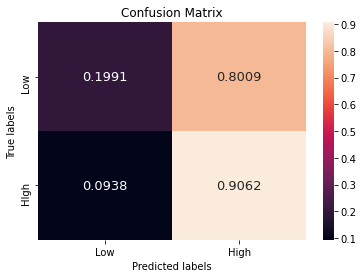

Precision: 0.6230  0.5924
Recall: 0.1991  0.9062
F1-Score 0.3018  0.7165
MCC 0.1506
AUROC 0.5527
XXXXX
['SingleMFE1', 'SingleMFE2']


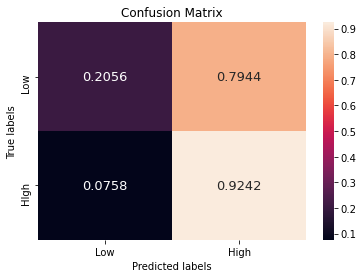

Precision: 0.6786  0.5991
Recall: 0.2056  0.9242
F1-Score 0.3156  0.7270
MCC 0.1899
AUROC 0.5649
XXXXX
['GC1', 'GC2', 'SingleMFE1', 'SingleMFE2', 'SingleCon1', 'SingleCon2', 'PairCon1', 'PairCon2']


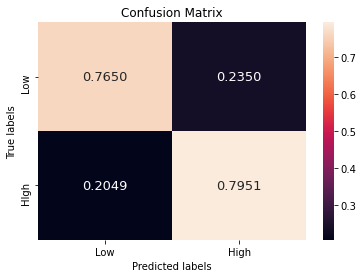

Precision: 0.7440  0.8129
Recall: 0.7650  0.7951
F1-Score 0.7544  0.8039
MCC 0.5585
AUROC 0.7801
XXXXX


In [97]:
for f in feats:
    tr, vl, ts, cols = get_scaled_abl(f)
    rf_model = RandomForestClassifier(n_jobs=32)
    rf_model.fit(tr, train_labels)
    y_pred_rf = rf_model.predict(ts)
    
    print(cols)
    report(test_labels, y_pred_rf)
    print('XXXXX')